# Solving Knapsack Problem with Genetic, Bee, and Ant Algorithms

Genetic Algorithm Source: "Hands-On Genetic Algorithms with Python" by Eyal Wirsansky. Packt Publishing. 2020.

## Knapsack Problem
Think of the familiar situation of packing for a long trip. There are many items that you would like to take with you, but you are limited by the capacity of your suitcase. In your mind, each item has a certain value it will add to your trip; at the same time, each has a size (and weight) associated with it, and each will compete with other items over the available space in your suitcase. This situation is just one of many real-life examples of the knapsack problem, which is considered one of the oldest and most investigated combinatorial search problems.

More formally, the knapsack problem consists of the following components:
- A set of items, each of them associated with a certain value and a certain weight.
- A bag/sack/container (the knapsack) of a certain weight capacity.

Our goal is to come up with a group of selected items that will provide the maximum total value, without exceeding the total weight capacity of the bag.

In the context of search algorithms, each subset of the items represents a state, and the set of all possible item subsets is considered the state space. For an instance of the knapsack 0-1 problem with n items, the size of the state space is $2^n$, which can quickly grow very large, even for a modest value of n.

In this (oroginal) version of the problem, each item can only be included once or not at all, and therefore it is sometimes referred to as the knapsack 0-1 problem. However, it can be expanded into other variants, for example, where items can be included multiple times (limited or unlimited), or where multiple knapsacks with varying capacities are present.

Applications of knapsack problems appear in many real-word processes that involve resource allocation and decision making, such as the selection of investments when building an investment portfolio, minimizing waste when cutting raw materials, and getting the most bang for your buck when selecting which questions to answer in a timed test.

## The Rosetta Code Knapsack 0-1 Problem
The Rosetta Code website ([rosettacode.org](https://rosettacode.org/wiki/Rosetta_Code)) provides a collection of programming tasks, each with contributed solutions in numerous languages. One of these tasks, described at [rosettacode.org/wiki/Knapsack_problem/0-1](https://rosettacode.org/wiki/Knapsack_problem/0-1), is a knapsack 0-1 problem where a tourist needs to decide which items to pack for his weekend trip. The tourist has 22 items he can choose from; each item was assigned by the tourist with some value that represents its relative importance for the upcoming journey.

The weight capacity of the tourist's bag in this problem is 400, and the list of item, along with their associated values and weights, is defines as follows.

In [2]:
from deap import base, creator, tools
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from time import time
from sys import getsizeof

In [3]:
max_capacity = 400

In [4]:
items = [
    # (item, weight, value)
    ("map", 9, 150),
    ("compass", 13, 35),
    ("water", 153, 200),
    ("sandwich", 50, 160),
    ("glucose", 15, 60),
    ("tin", 68, 45),
    ("banana", 27, 60),
    ("apple", 39, 40),
    ("cheese", 23, 30),
    ("beer", 52, 10),
    ("suntan cream", 11, 70),
    ("camera", 32, 30),
    ("t-shirt", 24, 15),
    ("trousers", 48, 10),
    ("umbrella", 73, 40),
    ("waterproof trousers", 42, 70),
    ("waterproof overclothes", 43, 75),
    ("note-case", 22, 80),
    ("sunglasses", 7, 20),
    ("towel", 18, 12),
    ("socks", 4, 50),
    ("book", 30, 10)
]

When solving the kanpsack 0-1 problem, a straightforward way to represent a solution is using a list of binary values. Every entry in that list corresponds to one of the items in the problem. For the Rosetta Code problem, a solution can be represented using a list of 22 integers of the values 0 or 1. A value of 1 represents picking the corresponding item, while a value of 0 means that the item has not been picked. When applying the genetic algorithms approach, the list of binary values is going to be used as the chromosome.

We have to remember, however, that the total weight of the choosen items cannot exceed the capacity of the knapsack. One way to incorporate this restriction into the solution is to wait until it gets evaluated. We then evaluate by adding the weights of the chosen items one by one, while ignoring any chosen item that will cause the accumulated weight to exceed the maximum allowed value. From the genetic algorithm point of view, this means that the chromosome representation of an andividial (genotype) may not entirely express itself when it gets tranlated into the actual solution (phenotype), as some of the 1 values in the chromosome may be ignored. This situation is sometimes referred to as genotype to phenotype mapping.

## Genetic Algorithms Solution
The chromosome representation we decided to use here is a list of integers with the values of 0 and 1. The genetic algorithm does not care what the chromosome represents (the phenotype) - a list of items to pack, some Boolean equation coefficients, or perhaps just some binary number - it is onlt concerned with the chromosome itself (the genotype) and the fitness value of that chromosome. Mapping the chromosome to the solution  it represents is carried out by the fitness evaluation function, which is implemented outside the genetic algorithm. In our case, this chromosome mapping and fitness calculation is implemented by the `get_value()` function.

In [5]:
def get_value(zero_one_list) -> int:
        """Calculates the value of the selected items in the list.
        
        It ignores items that will cause the accumulating 
        weight to exceed the maximum weight.
        
        Args:
            zero_one_list: a list of 0/1 values corresponding to the list of the 
            problem's items. '1' means that item was selected.
        
        Returns:
            The calculated value.
        """
        total_weight = total_value = 0

        for i in range(len(zero_one_list)):
            item, weight, value = items[i]
            if total_weight + weight <= max_capacity:
                total_weight += zero_one_list[i] * weight
                total_value += zero_one_list[i] * value
        return total_value

In [6]:
POPULATION_SIZE = 150
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 150

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

Create an operator that randomly returns 0 or 1.

In [7]:
toolbox.register("zeroOrOne", random.randint, 0, 1)

Define a single objective, maximizing fitness strategy.

In [8]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

Create the Individual class based on list.

In [9]:
creator.create("Individual", list, fitness=creator.FitnessMax)

Create the individual operator to fill up an Individual instance.

In [10]:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(items))

Create the population operator to generate a list of individuals.

In [11]:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

Define the `knapsack_value` fitness calculation function and register the `evaluate` tool.

In [12]:
def knapsack_value(individual):
    return get_value(individual),

toolbox.register("evaluate", knapsack_value)

In [13]:
# Tournament selection with tournament size of 3:
toolbox.register("select", tools.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", tools.cxTwoPoint)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be flipped
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(items))

Create initial population (generation 0).

In [14]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
print("Population size: %s" % (len(population)))
print("Individual size: %s" % (len(population[0])))
print("Individual sample: %s" % (population[0]))

Population size: 150
Individual size: 22
Individual sample: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]


In [15]:
generation_counter = 0

In [16]:
fitness_values = list(map(toolbox.evaluate, population))
print("Fitness value of one individual: %s" % (fitness_values[0]))

Fitness value of one individual: 337


In [17]:
for individual, fitness_value in zip(population, fitness_values):
    individual.fitness.values = fitness_value

In [18]:
fitness_values = [individual.fitness.values[0] for individual in population]
print("Fitness value of one individual: %s" % (fitness_values[0]))

Fitness value of one individual: 337.0


In [19]:
max_fitness_values = list()
mean_fitness_values = list()

# Genetic Algorithm (GA)

In [20]:
execution_times = []
individuals_sizeof = [getsizeof(ind) for ind in population]
population_sizeof = sum(individuals_sizeof)
best_fitness = -float('inf')
first_gen_best = None

while generation_counter < MAX_GENERATIONS:
    start_gen = time()
    generation_counter += 1

    # selection
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # mutation
    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # evaluate fresh individuals
    fresh_individuals = [individual for individual in offspring if not individual.fitness.valid]
    fresh_fitness_values = list(map(toolbox.evaluate, fresh_individuals))
    for individual, fitness_value in zip(fresh_individuals, fresh_fitness_values):
        individual.fitness.values = fitness_value

    # replace population
    population[:] = offspring
    print(offspring[0].fitness)

    # gather statistics
    fitness_values = [individual.fitness.values[0] for individual in population]
    max_fitness = max(fitness_values)
    mean_fitness = sum(fitness_values) / len(fitness_values)
    max_fitness_values.append(max_fitness)
    mean_fitness_values.append(mean_fitness)
    best_index = fitness_values.index(max(fitness_values))
    
    # First generation which has the best fitness
    if max_fitness > best_fitness:
        best_fitness = max_fitness
        first_gen_best = generation_counter
    
    end_gen = time()-start_gen
    execution_times.append(end_gen)
    print(f"Generation {generation_counter}: exec time (s) {end_gen:.4f}, max fitness {max_fitness}, mean fitness {mean_fitness}")
    print("Best individual = %s" % (population[best_index]))


(710.0,)
Generation 1: exec time (s) 0.0057, max fitness 920.0, mean fitness 716.04
Best individual = [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
(655.0,)
Generation 2: exec time (s) 0.0035, max fitness 920.0, mean fitness 786.0933333333334
Best individual = [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
(850.0,)
Generation 3: exec time (s) 0.0033, max fitness 930.0, mean fitness 819.5466666666666
Best individual = [1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
(850.0,)
Generation 4: exec time (s) 0.0030, max fitness 935.0, mean fitness 849.0733333333334
Best individual = [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
(895.0,)
Generation 5: exec time (s) 0.0028, max fitness 960.0, mean fitness 872.0733333333334
Best individual = [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
(895.0,)
Generation 6: exec time (s) 0.0027, max fitness 1010.0, mean fitness 895.3866666666667
Best individual

╒══════════════╤═════════════════════════════╤═══════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Generetions │   Max Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪═══════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│          150 │                       39600 │           150 │          1030 │       1024.07 │         0.26389 │           0.00175927 │
╘══════════════╧═════════════════════════════╧═══════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


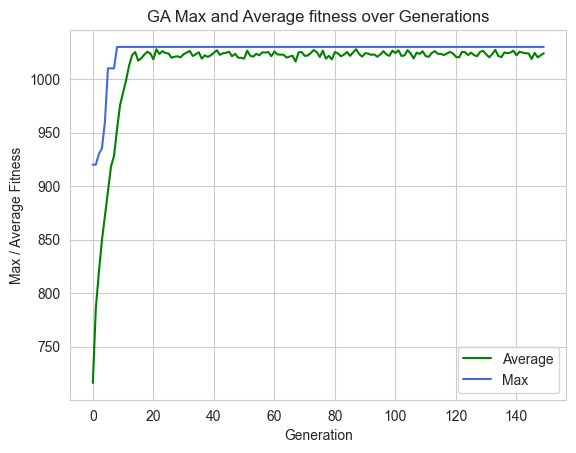

In [21]:
# visualize statistics
table = [['Population', 'Population sizeof (Bytes)', 'Generetions', 'Max Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [POPULATION_SIZE, population_sizeof, MAX_GENERATIONS, max_fitness_values[-1], mean_fitness_values[-1], np.sum(execution_times), np.mean(execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

sns.set_style("whitegrid")
plt.plot(mean_fitness_values, color='green', label='Average')
plt.plot(max_fitness_values, color='royalblue', label='Max')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('GA Max and Average fitness over Generations')
plt.legend()
plt.show()

The total value of 1030 is the known optimal solution for ths problem.

# Artificial Bee Colony (ABC) algorithm

In [22]:
def neighborhood(ind):
    """Generate a neighbor solution by swapping two random indices in the individual."""
    a, b = random.sample(range(len(ind)), 2)
    neighbor = ind[:]
    neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
    return neighbor

def artificial_bee_colony(fitness_evaluator, pop_size: int, max_cycles: int, limit: int) -> tuple[list, int, list, list, int, list, int]:
    """ Artificial Bee Colony algorithm for Knapsack problem.
    Args:
        fitness_evaluator: A function that evaluates the fitness of an individual.
        pop_size: The number of artificial bees in the population.
        max_cycles: Number of iterations to run the algorithm.
        limit: The number of cycles a bee can go without finding a better solution before becoming a scout.
    Returns:
        tuple: best solution, best fitness, history of best fitness, history of mean fitness, total population size in bytes, execution times, first iteration min fitness. 

    """
    def f_max(b):
        return -fitness_evaluator(b)[0]
        
    # Each bee holds a solution and a trial counter
    bees = [toolbox.individualCreator() for _ in range(pop_size)]
    fitness = [f_max(b) for b in bees]
    trials = [0]*pop_size
    bees_sizeof = [getsizeof(bee) for bee in bees]
    
    best = min(zip(bees, fitness), key=lambda x: x[1])
    best_history = []
    mean_history = []
    execution_times = []

    print("Iterations:")
    for cycle in range(max_cycles):
        start_time = time()
        # Employed bees phase
        for i in range(pop_size):
            neigh = neighborhood(bees[i])
            fit = f_max(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i], trials[i] = neigh, fit, 0
                if fit < best[1]:
                    best = (neigh, fit)
                    first_iter_min_fitness = cycle
            else:
                trials[i] += 1

        # Calculate selection probabilities for onlookers
        max_fit = max(fitness)
        probs = [ (max_fit - f + 1e-6) for f in fitness ]
        probs = [p/sum(probs) for p in probs]

        # Onlooker bees phase
        for _ in range(pop_size):
            i = random.choices(range(pop_size), probs)[0]
            neigh = neighborhood(bees[i])
            fit = f_max(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i], trials[i] = neigh, fit, 0
                if fit < best[1]:
                    best = (neigh, fit)
            else:
                trials[i] += 1

        # Scout bees phase
        for i in range(pop_size):
            if trials[i] > limit:
                bees[i] = toolbox.individualCreator()
                fitness[i] = f_max(bees[i])
                trials[i] = 0

        end_time = time()-start_time
        execution_times.append(end_time)
        best_history.append(-best[1])
        mean_history.append(-np.mean(fitness))
        print(f"{cycle} - Best fitness: {-best[1]} - Avg Fitness: {-np.mean(fitness):.4f} - Exec Time: {end_time:.4f}s")

    population_sizeof = sum(bees_sizeof)
    return best[0], -best[1], best_history, mean_history, population_sizeof, execution_times, first_iter_min_fitness

In [23]:
abc_population = POPULATION_SIZE
abc_iterations = MAX_GENERATIONS
trials_limit = 300
abc_sol, abc_val, abc_best_history, abc_mean_history, abc_population_sizeof, abc_execution_times, abc_first_iter_max_fitness = artificial_bee_colony(knapsack_value, pop_size=abc_population, max_cycles=abc_iterations, limit=trials_limit)
print("\nABC Best Solution", abc_sol)

Iterations:
0 - Best fitness: 855 - Avg Fitness: 595.3333 - Exec Time: 0.0038s
1 - Best fitness: 890 - Avg Fitness: 615.5733 - Exec Time: 0.0028s
2 - Best fitness: 900 - Avg Fitness: 635.4733 - Exec Time: 0.0040s
3 - Best fitness: 900 - Avg Fitness: 652.1333 - Exec Time: 0.0030s
4 - Best fitness: 900 - Avg Fitness: 669.4533 - Exec Time: 0.0026s
5 - Best fitness: 900 - Avg Fitness: 680.3133 - Exec Time: 0.0023s
6 - Best fitness: 925 - Avg Fitness: 693.6000 - Exec Time: 0.0022s
7 - Best fitness: 925 - Avg Fitness: 707.2533 - Exec Time: 0.0021s
8 - Best fitness: 925 - Avg Fitness: 719.6333 - Exec Time: 0.0021s
9 - Best fitness: 925 - Avg Fitness: 732.2200 - Exec Time: 0.0019s
10 - Best fitness: 925 - Avg Fitness: 740.6333 - Exec Time: 0.0020s
11 - Best fitness: 925 - Avg Fitness: 747.0467 - Exec Time: 0.0022s
12 - Best fitness: 932 - Avg Fitness: 755.8133 - Exec Time: 0.0020s
13 - Best fitness: 932 - Avg Fitness: 763.5200 - Exec Time: 0.0018s
14 - Best fitness: 932 - Avg Fitness: 772.5333

╒══════════════╤═════════════════════════════╤══════════════╤════════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Iterations │   Trials Limit │   Max Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪══════════════╪════════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│          150 │                       39600 │          150 │            300 │          1030 │         943.8 │        0.254197 │           0.00169465 │
╘══════════════╧═════════════════════════════╧══════════════╧════════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


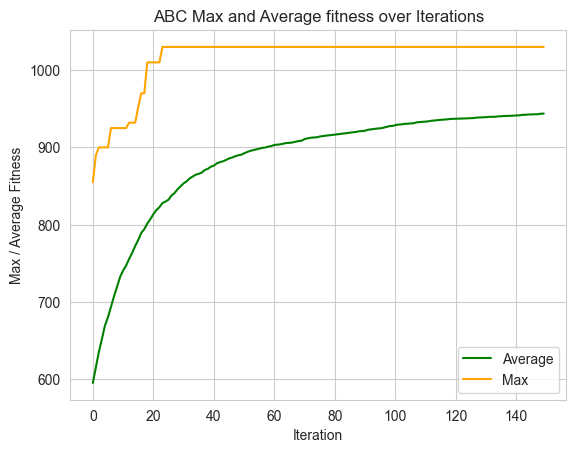

In [24]:
table = [['Population', 'Population sizeof (Bytes)', 'Iterations', 'Trials Limit', 'Max Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [abc_population, abc_population_sizeof, abc_iterations, trials_limit, abc_best_history[-1], abc_mean_history[-1], np.sum(abc_execution_times), np.mean(abc_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
sns.set_style("whitegrid")
plt.plot(abc_mean_history, color='green', label='Average')
plt.plot(abc_best_history, color='orange', label='Max')
plt.xlabel('Iteration')
plt.ylabel('Max / Average Fitness')
plt.title('ABC Max and Average fitness over Iterations')
plt.legend()
plt.show()

# Ant Colony Optimization (ACO) algorithm

In [84]:
def ant_colony_optimization(n_items: int, fitness_evaluator, pop_size: int, max_iters: int, alpha=1.5, beta=1.0, rho=0.3, Q=100.0) -> tuple[list, int, list, list, int, list]:
    """ Ant Colony Optimization for Knapsack problem.
    Args:
        n_items (int): Number of total items.
        fitness_evaluator: Function to evaluate the fitness of a solution.
        pop_size (int): Number of artificial ants to generate.
        max_cycles (int): Number of iterations to run the algorithm.
        alpha (float): Influence of the pheromone level (tau) in selecting an item (≥ 0).
        beta (float): Influence of the influence of the cost (eta) for selecting an item (≥ 0).
        rho (float): Pheromone evaporation rate (between 0 and 1).
        Q (float): Pheromone deposit constant.
    Returns:
        tuple: best solution, best fitness, history of best fitness, history of mean fitness, total population size in bytes, execution times, first iteration min fitness. 

    """
    # τ matrix [i, b]: pheromone for choosing bit b (0 or 1) at position i
    tau = np.ones((n_items, 2))
    # η matrix [i, b]: heuristic information (value-to-weight ratio for bit=1)
    eta = np.ones((n_items, 2))

    best_solution = None
    best_value = -float('inf')  # (+) for minimization; (-) for maximizing
    best_history = []
    mean_history = []
    ants_sizeof = []

    print("Iterations:")
    for cycle in range(max_iters):
        start_time = time()
        all_solutions = []
        all_fitness = []

        # Construct solutions for each ant
        for ant in range(pop_size):
            ants_sizeof.append(getsizeof(ant))
            solution = []
            for i in range(n_items):
                # Calculate probabilities for selecting 0 or 1
                probs = (tau[i, :] ** alpha) * (eta[i, :] ** beta)
                probs = probs / probs.sum() # Normalize probabilities

                # Sample bit according to probability distribution
                bit = np.random.choice([0, 1], p=probs)
                solution.append(bit)

            fitness = fitness_evaluator(solution)[0]
            all_solutions.append(solution)
            all_fitness.append(fitness)

            # Update best solution
            if fitness > best_value:
                best_value = fitness
                best_solution = solution.copy()
                first_iter_min_fitness = cycle

        # Evaporation
        tau *= (1 - rho)

        # Pheromone deposit
        for sol, fitness in zip(all_solutions, all_fitness):
            deposit_amt = Q / (1 + fitness)
            for idx, bit in enumerate(sol):
                tau[idx, bit] += deposit_amt

        end_time = time()-start_time
        execution_times.append(end_time)
        best_history.append(best_value)
        mean_history.append(np.mean(all_fitness))
        print(f"{cycle} - Best fitness: {best_value} - Avg Fitness: {np.mean(all_fitness):.4f} - Exec Time: {end_time:.4f}s")

    best_solution=[int(x) for x in best_solution]
    population_sizeof = sum(ants_sizeof)
    return best_solution, best_value, best_history, mean_history, population_sizeof, execution_times, first_iter_min_fitness


In [91]:
aco_population = POPULATION_SIZE
aco_iterations = MAX_GENERATIONS
aco_sol, aco_val, aco_best_history, aco_mean_history, aco_population_sizeof, aco_execution_times, aco_first_iter_max_fitness = ant_colony_optimization(len(items), knapsack_value, pop_size=aco_population, max_iters=aco_iterations)
print("\nACO Best Solution", aco_sol)

Iterations:
0 - Best fitness: 920 - Avg Fitness: 601.3400 - Exec Time: 0.0493s
1 - Best fitness: 940 - Avg Fitness: 552.3933 - Exec Time: 0.0464s
2 - Best fitness: 940 - Avg Fitness: 521.6000 - Exec Time: 0.0338s
3 - Best fitness: 940 - Avg Fitness: 496.0800 - Exec Time: 0.0320s
4 - Best fitness: 940 - Avg Fitness: 438.5200 - Exec Time: 0.0326s
5 - Best fitness: 940 - Avg Fitness: 397.4000 - Exec Time: 0.0413s
6 - Best fitness: 940 - Avg Fitness: 320.7400 - Exec Time: 0.0456s
7 - Best fitness: 940 - Avg Fitness: 286.4600 - Exec Time: 0.0417s
8 - Best fitness: 940 - Avg Fitness: 206.8933 - Exec Time: 0.0458s
9 - Best fitness: 940 - Avg Fitness: 170.3000 - Exec Time: 0.0458s
10 - Best fitness: 940 - Avg Fitness: 149.8533 - Exec Time: 0.0459s
11 - Best fitness: 940 - Avg Fitness: 122.8200 - Exec Time: 0.0454s
12 - Best fitness: 940 - Avg Fitness: 105.6200 - Exec Time: 0.0452s
13 - Best fitness: 940 - Avg Fitness: 97.9667 - Exec Time: 0.0460s
14 - Best fitness: 940 - Avg Fitness: 92.4000 -

╒══════════════╤═════════════════════════════╤══════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Iterations │   Max Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪══════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│          150 │                      630000 │          150 │           940 │            80 │          378.46 │            0.0433765 │
╘══════════════╧═════════════════════════════╧══════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


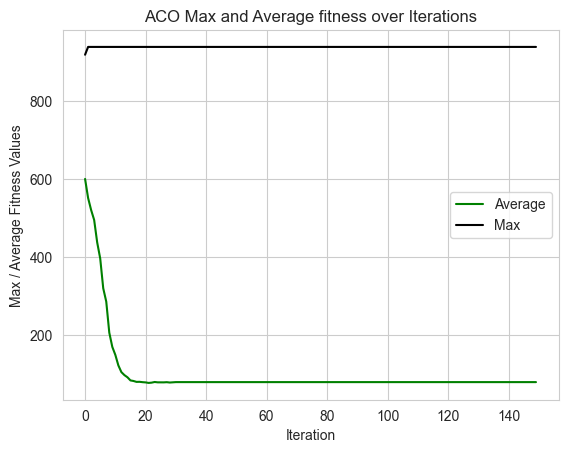

In [92]:
table = [['Population', 'Population sizeof (Bytes)', 'Iterations', 'Max Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [aco_population, aco_population_sizeof, aco_iterations, aco_best_history[-1], aco_mean_history[-1], np.sum(aco_execution_times), np.mean(aco_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
sns.set_style("whitegrid")
plt.plot(aco_mean_history, color='green', label='Average')
plt.plot(aco_best_history, color='black', label='Max')
plt.xlabel('Iteration')
plt.ylabel('Max / Average Fitness Values')
plt.title('ACO Max and Average fitness over Iterations')
plt.legend()
plt.show()

# GA vs ACO vs ABC

Comparing Genetic Algorithm, Ant Colony Optimization, and Artificial Bee Colony
╒═════════════╤═══════╤════════╤═══════════════╤═══════════════╤════════════════════════════════════════════╤═════════════════╕
│ Algorithm   │   Pop │   Iter │   Max Fitness │   Avg Fitness │   N° iter which achieved first max fitness │   Exec Time (s) │
╞═════════════╪═══════╪════════╪═══════════════╪═══════════════╪════════════════════════════════════════════╪═════════════════╡
│ GA          │   150 │    150 │          1030 │       1024.07 │                                          9 │      378.46     │
├─────────────┼───────┼────────┼───────────────┼───────────────┼────────────────────────────────────────────┼─────────────────┤
│ ACO         │   150 │    150 │           940 │         80    │                                          1 │      378.46     │
├─────────────┼───────┼────────┼───────────────┼───────────────┼────────────────────────────────────────────┼─────────────────┤
│ ABC         │   150 │ 

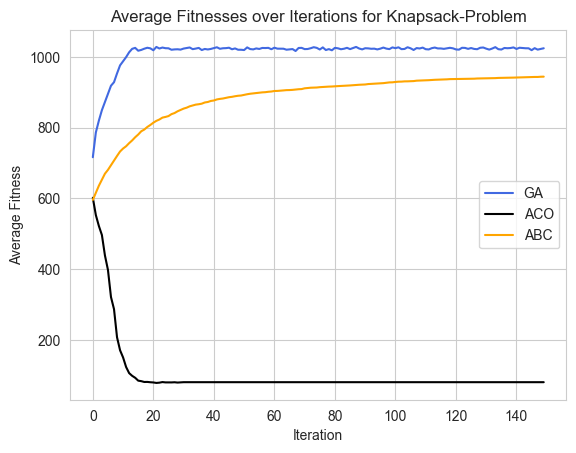

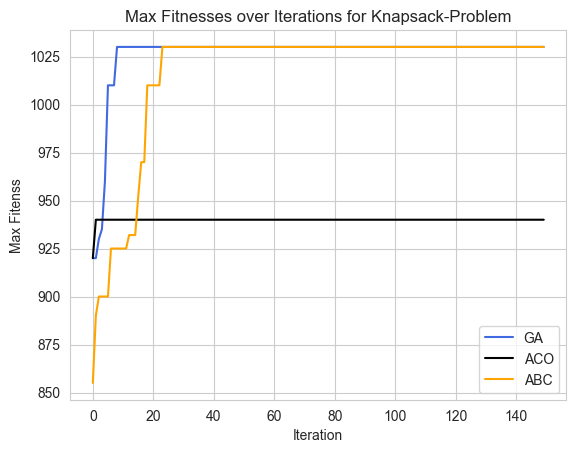

In [93]:
print("Comparing Genetic Algorithm, Ant Colony Optimization, and Artificial Bee Colony")

table = [['Algorithm', 'Pop', 'Iter', 'Max Fitness', 'Avg Fitness', 'N° iter which achieved first max fitness', 'Exec Time (s)'], 
         ['GA', POPULATION_SIZE, MAX_GENERATIONS, max_fitness_values[-1], mean_fitness_values[-1], first_gen_best, np.sum(execution_times)],
         ['ACO', aco_population, aco_iterations, aco_best_history[-1], aco_mean_history[-1], aco_first_iter_max_fitness, np.sum(aco_execution_times)],
         ['ABC', abc_population, abc_iterations, abc_best_history[-1], abc_mean_history[-1], abc_first_iter_max_fitness, np.sum(abc_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

sns.set_style("whitegrid")
plt.plot(mean_fitness_values, color='royalblue', label='GA')
plt.plot(aco_mean_history, color='black', label='ACO')
plt.plot(abc_mean_history, color='orange', label='ABC')
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.title('Average Fitnesses over Iterations for Knapsack-Problem')
plt.legend()
plt.show()

sns.set_style("whitegrid")
plt.plot(max_fitness_values, color='royalblue', label='GA')
plt.plot(aco_best_history, color='black', label='ACO')
plt.plot(abc_best_history, color='orange', label='ABC')
plt.xlabel('Iteration')
plt.ylabel('Max Fitenss')
plt.title('Max Fitnesses over Iterations for Knapsack-Problem')
plt.legend()
plt.show()